## Off-target frequency simulations

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from tapqir.models import Cosmos
from tapqir.utils.stats import ci_from_trace

### Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [3]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("lamda"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["lamda"] = truth[data_path.name]["lamda"]
        
        model = Cosmos()
        model.load(data_path, True, "cpu")
        model.load_parameters(param_path)
        mask = torch.from_numpy(model.data.labels["z"])
        samples = torch.masked_select(model.z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = model.z_marginal.flatten()

In [4]:
truth_df = pd.concat(truth.values(), axis=1).T.sort_values(by="lamda")
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,snr
lamda0.01,1.4,7.0,0.15,0.01,0.2,90.0,3000.0,150.0,3.758899
lamda0.05,1.4,7.0,0.15,0.05,0.2,90.0,3000.0,150.0,3.758899
lamda0.15,1.4,7.0,0.15,0.15,0.2,90.0,3000.0,150.0,3.758899
lamda0.5,1.4,7.0,0.15,0.50,0.2,90.0,3000.0,150.0,3.758899
lamda1,1.4,7.0,0.15,1.00,0.2,90.0,3000.0,150.0,3.758899


In [5]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by="lamda")
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,Recall,Precision,TN,FP,FN,TP,z_median,z_ll,z_ul,lamda
lamda0.01,3.740959,7.003331,7.003331,7.003331,0.146225,0.146225,0.146225,0.011004,0.011004,0.011004,...,1.000000,1.000000,2142.0,0.0,0.0,358.0,0.999849,0.999711,0.999895,0.01
lamda0.05,3.748954,6.995525,6.995525,6.995525,0.145051,0.145051,0.145051,0.051432,0.051432,0.051432,...,0.986034,0.994366,2140.0,2.0,5.0,353.0,0.999297,0.998651,0.999506,0.05
lamda0.15,3.767562,6.999659,6.999659,6.999659,0.147087,0.147087,0.147087,0.136816,0.136816,0.136816,...,0.977654,0.980392,2135.0,7.0,8.0,350.0,0.997925,0.995820,0.998526,0.15
lamda0.5,3.807789,7.030880,7.030880,7.030880,0.141167,0.141167,0.141167,0.492269,0.492269,0.492269,...,0.949721,0.965909,2130.0,12.0,18.0,340.0,0.992178,0.981530,0.995503,0.50
lamda1,3.837327,7.041692,7.041692,7.041692,0.134233,0.134233,0.134233,0.974017,0.974017,0.974017,...,0.910615,0.953216,2126.0,16.0,32.0,326.0,0.984635,0.957786,0.991965,1.00


### Figure 2

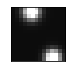

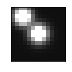

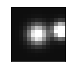

In [6]:
model = models["lamda0.5"]
n = ontarget = 0
frames = [175, 251, 252]

for f in frames:
    img_ideal = model.data.offset_mean + pyro.param("d/b_loc").data[n, f:f+1, None, None]
    gaussian = model.data_loc(
        pyro.param("d/h_loc").data[:, n, f:f+1].masked_fill(model.m_probs[:, n, f:f+1] < 0.5, 0.),
        pyro.param("d/w_mean").data[:, n, f:f+1],
        pyro.param("d/x_mean").data[:, n, f:f+1],
        pyro.param("d/y_mean").data[:, n, f:f+1],
        n, torch.arange(f,f+1)
    )
    img_ideal = img_ideal + gaussian.sum(-4)
    
    plt.figure(figsize=(1., 1.))
    plt.imshow(img_ideal[0].numpy(), vmin=230, vmax=380, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig(f"/tmp/theta0.png", dpi=300)
    plt.show()

### Figure 3

In [51]:
n = ontarget = 4
frames = [155, 158, 160, 163, 165, 168, 170, 173, 175]
vmin, vmax = model.data.vmin, model.data.vmax

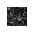

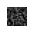

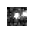

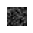

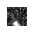

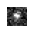

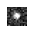

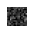

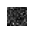

In [52]:
for f in frames:
    plt.figure(figsize=(0.35, 0.35))
    plt.axis("off")
    plt.imshow(model.data[ontarget, f+50].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    plt.savefig(f"/tmp/simdna{f}.png", dpi=600)
    plt.show()

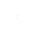

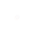

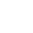

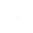

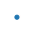

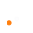

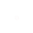

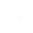

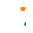

In [53]:
for f in frames:
    fig = plt.figure(figsize=(0.35, 0.35))

    plt.imshow(np.ones((model.data.D, model.data.D)),
               vmin=0, vmax=1, cmap="gray")
    # add patch
    for k in range(2):
        plt.gca().add_patch(
            Circle(
                (model.data.target_locs[n, f, 1] +
                 pyro.param("d/y_mean")[k, n, f].item() + 0.5,
                 model.data.target_locs[n, f, 0] +
                 pyro.param("d/x_mean")[k, n, f].item() + 0.5),
                1.5, color=f"C{k}", alpha=model.m_probs[k, n, f].item()
            )
        )
    plt.axis("off")
    plt.savefig(f"/tmp/simpoints{f}.png", dpi=600)
    plt.show()

In [54]:
f1, f2 = 155, 176

model.n = torch.tensor([n])
trace = pyro.poutine.trace(model.guide).get_trace()

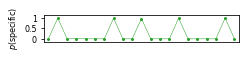

In [55]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_probs[:, n, f1:f2].sum(0),
    "o-", ms=2, lw=0.5, color="C2", label="on-target"
)
#plt.plot(
#    np.arange(f1, f2),
#    1 - (1 - model.j_probs[:, n, f1:f2]).prod(0),
#    "o-", ms=2, lw=0.5, color="C3", label="off-target"
#)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\mathrm{specific})$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/tmp/ratej-p.svg")
plt.show()

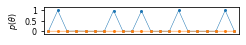

In [56]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$\theta=1$"
)
plt.plot(
    np.arange(f1, f2),
    model.z_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$\theta=2$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\theta)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/tmp/ratej-z.svg")
plt.show()

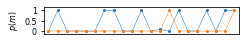

In [57]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.m_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$m_{1}$"
)
plt.plot(
    np.arange(f1, f2),
    model.m_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$m_{2}$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(m)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/tmp/ratej-m.svg")
plt.show()

In [58]:
sites = [
    "d/height_0",
    "d/height_1",
    "d/width_0",
    "d/width_1",
    "d/x_0",
    "d/x_1",
    "d/y_0",
    "d/y_1",
    "d/background",
]
ci_stats = ci_from_trace(trace, sites)

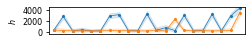

In [59]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/height_{k}"]["ll"][f1:f2], ci_stats[f"d/height_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/height_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([0, 2000, 4000], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-500, 4500)
plt.ylabel(r"$h$", fontsize=8)

plt.savefig("/tmp/ratej-h.svg")
plt.show()

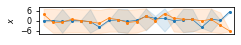

In [60]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["ll"][f1:f2], ci_stats[f"d/x_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$x$", fontsize=8)

plt.savefig("/tmp/lamda-x.svg")
plt.show()

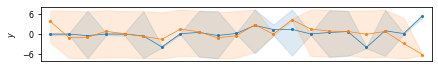

In [61]:
plt.figure(figsize=(7,1))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["ll"][f1:f2], ci_stats[f"d/x_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$y$", fontsize=8)

plt.savefig("/tmp/lamda-y.svg")
plt.show()

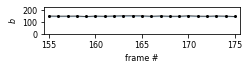

In [21]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    ci_stats["d/background"]["mean"][f1:f2],
    "o-", ms=2, lw=0.7, color="k"
)
plt.fill_between(
    np.arange(f1, f2),
    ci_stats["d/background"]["ll"][f1:f2], ci_stats["d/background"]["ul"][f1:f2],
    alpha=0.15, color="C0"
)

plt.xticks(np.arange(f1, f2+5, 5), fontsize=8)
plt.yticks([0, 100, 200], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(0, 230)
plt.ylabel(r"$b$", fontsize=8)
#plt.legend(fontsize=8)
plt.xlabel("frame #", fontsize=8)

plt.savefig("/tmp/lamda-b.svg")
plt.show()

### Figure 5

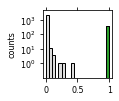

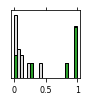

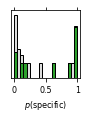

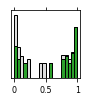

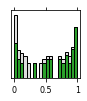

In [13]:
for name in fit_df.index:
    fig, ax = plt.subplots(figsize=(1.25, 1.25))
    ax.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    ax.hist(predictions[name]["z_masked"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    ax.set_yscale("log")
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(1e-1, 5e3)
    ax.set_xticks([0, 0.5, 1])
    ax.tick_params(axis="x", labelsize=8, top=True)
    
    if name == "lamda0.01":
        ax.set_ylabel("counts", fontsize=8)
        ax.set_yticks([1, 10, 100, 1000])
        ax.tick_params(axis="y", labelsize=8)
    else:
        ax.set_yticks([])
        ax.tick_params(axis="y", labelsize=8)
    if name == "lamda0.15":
        ax.set_xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/logdensity-{name}.svg")
    plt.show()

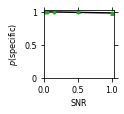

In [14]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.errorbar(truth_df["lamda"], fit_df["z_median"],
             yerr=abs(fit_df[["z_ll", "z_ul"]].values.T-fit_df["z_median"].values),
             fmt="o-", ms=3, color="k", mfc="C2", mec="C2", ecolor="C2", capsize=2)
ax.set_xlim(0, 1.03)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel("SNR", fontsize=8)
ax.set_ylabel(r"$p(\mathsf{specific})$", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.savefig("/tmp/lamda-errorbar.svg")
plt.show()

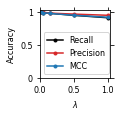

In [15]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.plot(truth_df["lamda"], fit_df["Recall"], "o-", color="k", ms=3, label="Recall")
ax.plot(truth_df["lamda"], fit_df["Precision"], "o-", color="C3", ms=3, label="Precision")
ax.plot(truth_df["lamda"], fit_df["MCC"], "o-", color="C0", ms=3, label="MCC")
ax.set_xlim(0, 1.03)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel(r"$\lambda$", fontsize=8)
ax.set_ylabel("Accuracy", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.legend(fontsize=8)
plt.savefig("/tmp/lamda-mcc.svg")
plt.show()

### Analysis

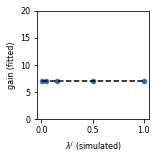

In [28]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["gain"], s=20)
plt.ylim(0, 20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel("gain (fitted)", fontsize=8)
plt.show()

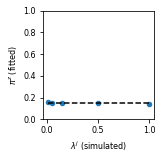

In [27]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["probs_z"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["probs_z_1"], s=20)
plt.ylim(0, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\pi^z$ (fitted)", fontsize=8)
plt.show()

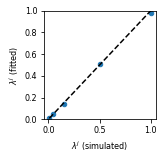

In [25]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["rate_j"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["rate_j"], s=20)
plt.ylim(0, 1.)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\lambda^j$ (fitted)", fontsize=8)
plt.show()

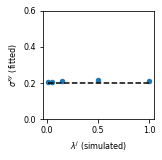

In [26]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["proximity_0"], s=20)
plt.ylim(0., 0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fitted)", fontsize=8)
plt.show()